In [1]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

# Summary

Face recognition models are regular convolutional neural networks models. They represent face photos as vectors. We find the distance between these two vectors to compare two faces. Finally, we classify two faces as same person whose distance is less than a threshold value.

The question is that how to determine the threshold. In this notebook, we will find the best split point for a threshold.

# Data set

In [2]:
# Ref: https://github.com/serengil/deepface/tree/master/tests/dataset
idendities = {
    "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg", "img5.jpg", "img6.jpg", "img7.jpg", "img10.jpg", "img11.jpg"],
    "Scarlett": ["img8.jpg", "img9.jpg"],
    "Jennifer": ["img3.jpg", "img12.jpg"],
    "Mark": ["img13.jpg", "img14.jpg", "img15.jpg"],
    "Jack": ["img16.jpg", "img17.jpg"],
    "Elon": ["img18.jpg", "img19.jpg"],
    "Jeff": ["img20.jpg", "img21.jpg"],
    "Marissa": ["img22.jpg", "img23.jpg"],
    "Sundar": ["img24.jpg", "img25.jpg"]
}

# Positive samples
Find different photos of same people

In [3]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

In [4]:
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

# Negative samples
Compare photos of different people

In [5]:
samples_list = list(idendities.values())

In [6]:
negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)
        

In [7]:
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

# Merge Positives and Negative Samples

In [8]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [9]:
df.shape

(300, 3)

In [10]:
df.decision.value_counts()

No     262
Yes     38
Name: decision, dtype: int64

In [11]:
df.file_x = "deepface/tests/dataset/"+df.file_x
df.file_y = "deepface/tests/dataset/"+df.file_y

# DeepFace

In [12]:
from deepface import DeepFace

Using TensorFlow backend.


In [13]:
instances = df[["file_x", "file_y"]].values.tolist()

In [14]:
model_name = "VGG-Face"
distance_metric = "cosine"

In [15]:
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric)

Using VGG-Face model backend and cosine distance.


Verification: 100%|██████████| 300/300 [11:35<00:00,  2.32s/it]


In [16]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [17]:
df["distance"] = distances

# Analyzing Distances

In [18]:
tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
tp_std = round(df[df.decision == "Yes"].std().values[0], 4)
fp_mean = round(df[df.decision == "No"].mean().values[0], 4)
fp_std = round(df[df.decision == "No"].std().values[0], 4)

In [19]:
print("Mean of true positives: ", tp_mean)
print("Std of true positives: ", tp_std)
print("Mean of false positives: ", fp_mean)
print("Std of false positives: ", fp_std)

Mean of true positives:  0.2263
Std of true positives:  0.0744
Mean of false positives:  0.6489
Std of false positives:  0.12


# Distribution

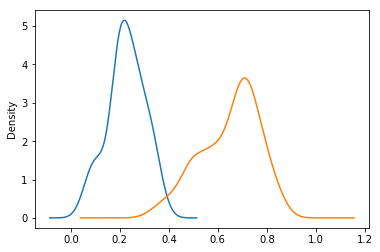

In [25]:
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

# Best Split Point

In [27]:
from chefboost import Chefboost as chef

In [26]:
config = {'algorithm': 'C4.5'}

In [28]:
tmp_df = df[['distance', 'decision']].rename(columns = {"decision": "Decision"}).copy()
model = chef.fit(tmp_df, config)

C4.5  tree is going to be built...
Accuracy:  98.66666666666667 % on  300  instances
finished in  3.5094187259674072  seconds


# Sigma

In [114]:
sigma = 2
#2 sigma corresponds 95.45% confidence, and 3 sigma corresponds 99.73% confidence

#threshold = round(tp_mean + sigma * tp_std, 4)
threshold = 0.3147 #comes from c4.5 algorithm
print("threshold: ", threshold)

threshold:  0.3147


In [115]:
df[df.decision == 'Yes'].distance.max()

0.3637

In [116]:
df[df.decision == 'No'].distance.min()

0.3186

# Evaluation

In [117]:
df["prediction"] = "No"

In [118]:
idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'

In [119]:
df.sample(5)

,file_x,file_y,decision,distance,prediction
150,deepface/tests/dataset/img16.jpg,deepface/tests/dataset/img4.jpg,No,0.7178,No
25,deepface/tests/dataset/img4.jpg,deepface/tests/dataset/img7.jpg,Yes,0.2450,Yes
214,deepface/tests/dataset/img24.jpg,deepface/tests/dataset/img4.jpg,No,0.7362,No
135,deepface/tests/dataset/img16.jpg,deepface/tests/dataset/img14.jpg,No,0.5281,No
63,deepface/tests/dataset/img19.jpg,deepface/tests/dataset/img23.jpg,No,0.6546,No


In [120]:
cm = confusion_matrix(df.decision.values, df.prediction.values)

In [121]:
cm

array([[262,   0],
       [  4,  34]], dtype=int64)

In [122]:
tn, fp, fn, tp = cm.ravel()

In [123]:
tn, fp, fn, tp

(262, 0, 4, 34)

In [124]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [125]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  100.0 %
Recall:  89.47368421052632 %
F1 score  94.44444444444444 %
Accuracy:  98.66666666666667 %


In [127]:
df.to_csv("threshold_pivot.csv", index = False)

## Test results

### Threshold = 0.3147 (C4.5 best split point)

Precision:  100.0 %

Recall:  89.47368421052632 %

F1 score  94.44444444444444%

Accuracy:  98.66666666666667 %

### Threshold = 0.3751 (2 sigma)

Precision:  90.47619047619048 %

Recall:  100.0 %

F1 score  95.0 %

Accuracy:  98.66666666666667 %